In [1]:
import pandas as pd

In [2]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [5]:
def feature_engineering(df):
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)

    #df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    #df['Age'] = df['Age'].fillna(df['Age'].mean())
    #df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)    
    
    return df

In [6]:
import re 
def preprocessing_data(df):
    
    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    
    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    new_state = new_state.drop(columns = ['count'])
    
    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    new_country = new_country.drop(columns = ['count'])
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    
    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])
    
    return df
    

In [7]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()


train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

# 평점 binary 분류
#zero_user = train[train['Book-Rating'] == 0][['User-ID', 'Book-Rating']].drop_duplicates()['User-ID']
train_lb['Rating_gb'] = np.where(train_lb['Book-Rating'] == 0, 0, 1)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))


In [8]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Rating', 'Rating_gb'])
x_test = test_lb.drop(columns = ['ID'])
y_train_cf = train_lb['Rating_gb']

In [9]:
X_train[X_train['Age_gb'].isna()]

,User-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country,Age_gb


In [10]:
# model1. binary classifier of 0 or other
from sklearn.model_selection import KFold, StratifiedKFold
k = 5 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)

from catboost import CatBoostClassifier, Pool
model_cf = CatBoostClassifier(loss_function='Logloss', iterations =3000, auto_class_weights='SqrtBalanced')

y_train_prob = 0
y_test_prob = 0

from sklearn.model_selection import train_test_split
FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train_cf))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train_cf.iloc[train_index], y_train_cf.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model_cf.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True,
                          early_stopping_rounds=50,
                          verbose=50
                          )
    print( "  N trees = ", model_cf.tree_count_ )      
  
    X_train[FEATURE] = X_train[FEATURE].astype('int')
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    
    y_train_prob +=  fit_model.predict_proba(X_train)
    y_test_prob +=  fit_model.predict_proba(x_test)
y_train_prob /= k
y_test_prob /= k  

0it [00:00, ?it/s]


Fold  0
Learning rate set to 0.099005
0:	learn: 0.6626952	test: 0.6605745	best: 0.6605745 (0)	total: 419ms	remaining: 20m 55s
50:	learn: 0.5340554	test: 0.5158666	best: 0.5158666 (50)	total: 11s	remaining: 10m 38s
100:	learn: 0.5314537	test: 0.5133395	best: 0.5133395 (100)	total: 34.8s	remaining: 16m 38s
150:	learn: 0.5298264	test: 0.5120098	best: 0.5120098 (150)	total: 1m 1s	remaining: 19m 16s
200:	learn: 0.5283915	test: 0.5108950	best: 0.5108950 (200)	total: 1m 32s	remaining: 21m 31s
250:	learn: 0.5274499	test: 0.5102566	best: 0.5102566 (250)	total: 2m 2s	remaining: 22m 26s
300:	learn: 0.5267947	test: 0.5098541	best: 0.5098541 (300)	total: 2m 31s	remaining: 22m 36s
350:	learn: 0.5260768	test: 0.5094397	best: 0.5094397 (350)	total: 3m	remaining: 22m 40s
400:	learn: 0.5254191	test: 0.5090701	best: 0.5090701 (400)	total: 3m 27s	remaining: 22m 24s
450:	learn: 0.5249716	test: 0.5089003	best: 0.5089003 (450)	total: 3m 53s	remaining: 22m 1s
500:	learn: 0.5244612	test: 0.5087029	best: 0.508

1it [16:19, 979.45s/it]


Fold  1
Learning rate set to 0.099005
0:	learn: 0.6625325	test: 0.6604588	best: 0.6604588 (0)	total: 288ms	remaining: 14m 23s
50:	learn: 0.5333782	test: 0.5165956	best: 0.5165956 (50)	total: 10.8s	remaining: 10m 23s
100:	learn: 0.5307410	test: 0.5143326	best: 0.5143326 (100)	total: 33s	remaining: 15m 48s
150:	learn: 0.5290466	test: 0.5129646	best: 0.5129646 (150)	total: 1m 1s	remaining: 19m 20s
200:	learn: 0.5276947	test: 0.5119416	best: 0.5119416 (200)	total: 1m 31s	remaining: 21m 8s
250:	learn: 0.5268469	test: 0.5114730	best: 0.5114730 (250)	total: 1m 58s	remaining: 21m 36s
300:	learn: 0.5261342	test: 0.5111029	best: 0.5111029 (300)	total: 2m 27s	remaining: 22m 6s
350:	learn: 0.5254917	test: 0.5107899	best: 0.5107899 (350)	total: 2m 58s	remaining: 22m 28s
400:	learn: 0.5248478	test: 0.5105021	best: 0.5105017 (399)	total: 3m 27s	remaining: 22m 22s
450:	learn: 0.5243437	test: 0.5102720	best: 0.5102720 (450)	total: 3m 55s	remaining: 22m 9s
500:	learn: 0.5238264	test: 0.5101159	best: 0.

2it [31:24, 935.97s/it]


Fold  2
Learning rate set to 0.099005
0:	learn: 0.6625614	test: 0.6605742	best: 0.6605742 (0)	total: 290ms	remaining: 14m 29s
50:	learn: 0.5335051	test: 0.5162511	best: 0.5162511 (50)	total: 11.7s	remaining: 11m 19s
100:	learn: 0.5308712	test: 0.5138129	best: 0.5138129 (100)	total: 35.3s	remaining: 16m 53s
150:	learn: 0.5291272	test: 0.5123923	best: 0.5123923 (150)	total: 1m 1s	remaining: 19m 18s
200:	learn: 0.5279854	test: 0.5115329	best: 0.5115329 (200)	total: 1m 29s	remaining: 20m 43s
250:	learn: 0.5271248	test: 0.5108939	best: 0.5108939 (250)	total: 1m 56s	remaining: 21m 14s
300:	learn: 0.5263871	test: 0.5104325	best: 0.5104325 (300)	total: 2m 23s	remaining: 21m 29s
350:	learn: 0.5257764	test: 0.5101003	best: 0.5101003 (350)	total: 2m 51s	remaining: 21m 37s
400:	learn: 0.5252680	test: 0.5098884	best: 0.5098837 (396)	total: 3m 17s	remaining: 21m 22s
450:	learn: 0.5247638	test: 0.5096444	best: 0.5096444 (450)	total: 3m 45s	remaining: 21m 16s
500:	learn: 0.5242988	test: 0.5094502	bes

3it [47:40, 953.98s/it]


Fold  3
Learning rate set to 0.099005
0:	learn: 0.6624606	test: 0.6600378	best: 0.6600378 (0)	total: 269ms	remaining: 13m 26s
50:	learn: 0.5335063	test: 0.5153236	best: 0.5153236 (50)	total: 10.8s	remaining: 10m 21s
100:	learn: 0.5308606	test: 0.5126873	best: 0.5126873 (100)	total: 33s	remaining: 15m 47s
150:	learn: 0.5293241	test: 0.5114695	best: 0.5114695 (150)	total: 1m	remaining: 18m 59s
200:	learn: 0.5279960	test: 0.5103615	best: 0.5103615 (200)	total: 1m 28s	remaining: 20m 31s
250:	learn: 0.5270373	test: 0.5097771	best: 0.5097771 (250)	total: 1m 59s	remaining: 21m 47s
300:	learn: 0.5262793	test: 0.5093298	best: 0.5093298 (300)	total: 2m 28s	remaining: 22m 13s
350:	learn: 0.5256959	test: 0.5090353	best: 0.5090353 (350)	total: 2m 59s	remaining: 22m 37s
400:	learn: 0.5251220	test: 0.5087826	best: 0.5087799 (397)	total: 3m 29s	remaining: 22m 37s
450:	learn: 0.5245488	test: 0.5084728	best: 0.5084711 (447)	total: 4m	remaining: 22m 39s
500:	learn: 0.5241062	test: 0.5083246	best: 0.5083

4it [1:01:31, 905.44s/it]


Fold  4
Learning rate set to 0.099005
0:	learn: 0.6623478	test: 0.6596717	best: 0.6596717 (0)	total: 286ms	remaining: 14m 18s
50:	learn: 0.5336119	test: 0.5164099	best: 0.5164099 (50)	total: 11.9s	remaining: 11m 27s
100:	learn: 0.5307153	test: 0.5139001	best: 0.5139001 (100)	total: 36.7s	remaining: 17m 33s
150:	learn: 0.5291675	test: 0.5126213	best: 0.5126213 (150)	total: 1m 4s	remaining: 20m 15s
200:	learn: 0.5279436	test: 0.5116336	best: 0.5116336 (200)	total: 1m 33s	remaining: 21m 40s
250:	learn: 0.5270841	test: 0.5110577	best: 0.5110577 (250)	total: 2m 2s	remaining: 22m 18s
300:	learn: 0.5263019	test: 0.5105914	best: 0.5105914 (300)	total: 2m 30s	remaining: 22m 29s
350:	learn: 0.5257305	test: 0.5103419	best: 0.5103413 (342)	total: 2m 59s	remaining: 22m 33s
400:	learn: 0.5251979	test: 0.5100853	best: 0.5100849 (399)	total: 3m 28s	remaining: 22m 33s
450:	learn: 0.5246797	test: 0.5098896	best: 0.5098896 (450)	total: 3m 57s	remaining: 22m 20s
500:	learn: 0.5241695	test: 0.5096590	best

5it [1:13:10, 878.07s/it]


In [11]:
X_train['RT_prob_0'] = y_train_prob[:,0]
X_train['RT_prob_1'] = y_train_prob[:,1]
x_test['RT_prob_0'] = y_test_prob[:,0]
x_test['RT_prob_1'] = y_test_prob[:,1]

In [12]:
X_train

,User-ID,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country,Age_gb,RT_prob_0,RT_prob_1
0,0,23.0,136251,77475,2001.0,9093,10487,1037,57,2,0.309138,0.690862
1,0,23.0,103076,91647,1981.0,10515,10487,1037,57,2,0.225929,0.774071
2,0,23.0,208319,90102,1981.0,10515,10487,1037,57,2,0.502943,0.497057
3,0,23.0,111765,83754,1991.0,1166,10487,1037,57,2,0.479605,0.520395
4,0,23.0,143993,54167,1989.0,12609,10487,1037,57,2,0.258258,0.741742
...,...,...,...,...,...,...,...,...,...,...,...,...
871388,83251,34.0,73499,52004,1993.0,6162,7728,955,323,3,0.612918,0.387082
871389,83252,35.0,186183,16876,2002.0,6091,12055,1534,323,5,0.400210,0.599790
871390,83253,45.0,72770,36822,2000.0,13698,9067,1160,57,6,0.469678,0.530322
871391,83254,43.0,73851,87010,1996.0,12989,7277,955,323,5,0.221370,0.778630


In [13]:
y_train = train_lb['Book-Rating']

<Figure size 700x700 with 0 Axes>

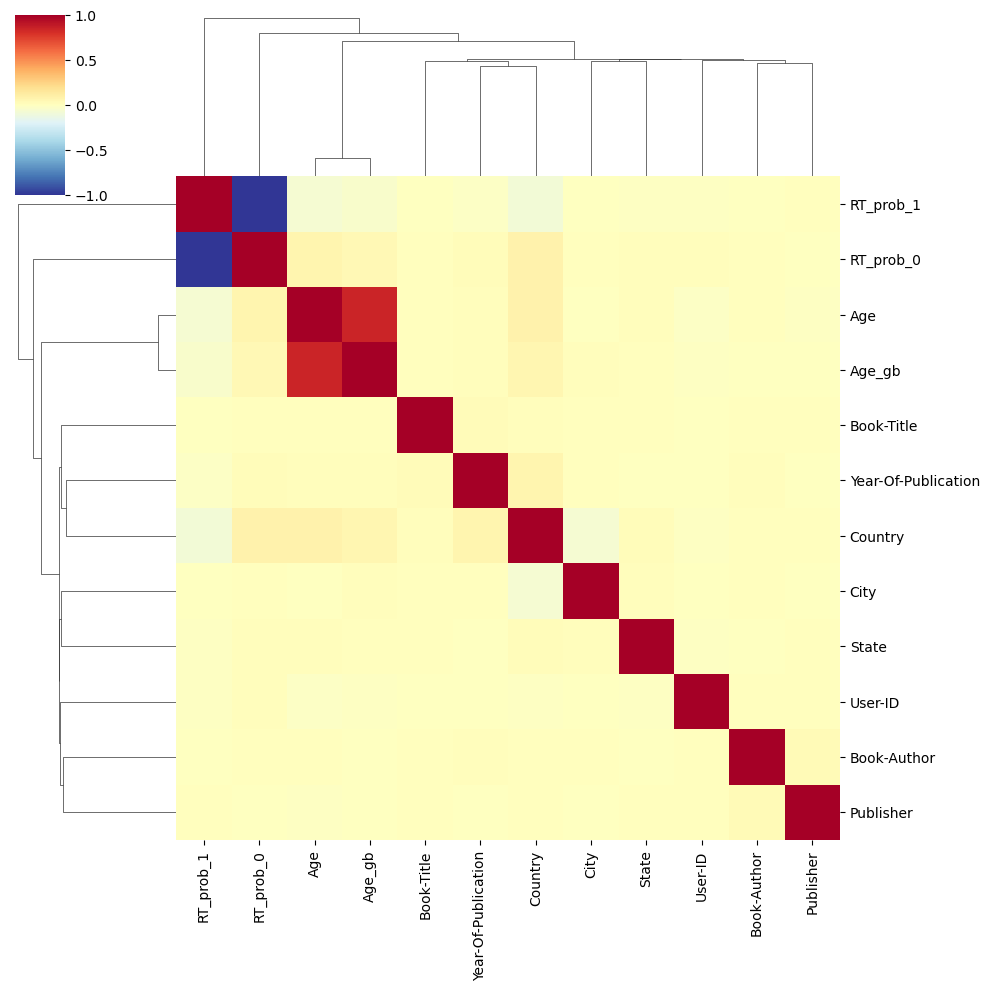

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), cmap = 'RdYlBu_r',vmin = -1, vmax = 1, annot = False)

In [15]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Rating_gb']# 'Pub_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8223161	test: 3.8222039	best: 3.8222039 (0)	total: 187ms	remaining: 27m 1s
500:	learn: 1.7108383	test: 1.5967184	best: 1.5967184 (500)	total: 1m 16s	remaining: 20m 50s
1000:	learn: 1.6023108	test: 1.4688034	best: 1.4688034 (1000)	total: 2m 28s	remaining: 19m
1500:	learn: 1.5517006	test: 1.4188084	best: 1.4188084 (1500)	total: 3m 34s	remaining: 17m 8s
2000:	learn: 1.5159976	test: 1.3895094	best: 1.3895094 (2000)	total: 4m 38s	remaining: 15m 32s
2500:	learn: 1.4897202	test: 1.3717414	best: 1.3717414 (2500)	total: 5m 46s	remaining: 14m 17s
3000:	learn: 1.4681460	test: 1.3584657	best: 1.3584657 (3000)	total: 6m 56s	remaining: 13m 10s
3500:	learn: 1.4495691	test: 1.3483497	best: 1.3483497 (3500)	total: 8m 2s	remaining: 11m 55s
4000:	learn: 1.4323839	test: 1.3400494	best: 1.3400494 (4000)	total: 9m 9s	remaining: 10m 44s
4500:	learn: 1.4173941	test: 1.3333671	best: 1.3333671 (4500)	total: 10m 14s	remaining: 9m 32s
5000:	learn: 1.4029821	test: 1.3270931	best: 1.3270931 (50

In [ ]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [ ]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

In [ ]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [ ]:
sub.to_csv('submit_cat+20-folds+binary.csv', index=False,encoding="utf-8-sig")